# Welcome to YelpHelp! 

# The purpose of this notebook is to build a model that classifies whether a Yelp review comes from a stable period in a restaurant's history or from a "tipping point" after which there will be a decline in user satisfaction. 

## The code is organized into a number of different sections: <br> <br> First I'll load in the module I wrote to process these reviews as well as other useful modules, and then we'll create connections to the SQL databases for the businesses and reviews. <br> <br> Second I'll do data exploration to learn something about tipping point reviews. <br><br> Third, I'll process all of the reviews to generate features for the model and then split it into training and testing sets. <br> <br> Finally, I'll train the model and then compare it to other possible approaches. 

# Step 1: Set up approach

## Import packages

In [1]:
#Load from the yelphelp package I wrote to get functions for querying our databases,
#processing the reviews to derive features, building the bag of words representation
#and visualizing the results
from yelphelp.queries import query_business_switchpoints, query_business_reviews
from yelphelp.pp_switchpoints import mcmc_changepoint
from yelphelp.data_prep import get_business_class, sample_reviews, scale_features
from yelphelp.nlp_tools import create_nlp_features, get_pos_dist, service_complaint
from yelphelp.viz_tools import make_roc

#SQL dependencies
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

#I/O
import json
import os
import time
import datetime

#Analysis/Data organization
import numpy as np
import pandas as pd
from collections import Counter
from scipy import sparse
from scipy import interpolate
import scipy as sp
import scipy.io
import math
from sklearn.utils import shuffle

#NLP & Feature Analysis
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import model_selection, preprocessing, ensemble
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.tokenize import RegexpTokenizer  
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Visualization/Plotting
import matplotlib.pyplot as plt

#Probabilistic Programming
import pymc3 as pm
from pymc3 import Model, DiscreteUniform, Exponential, Poisson, Normal 
from pymc3 import HalfNormal, NUTS, Metropolis, sample, traceplot, find_MAP
from pymc3.math import switch

#Modeling
import xgboost as xgb 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import log_loss

#Saving results
import pickle

#Visualization
from bokeh.plotting import figure, output_file, show
from wordcloud import WordCloud

/home/steven/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Establish connections to the SQL databases we need

### There are three relevant databases: "Reviews" which contains ~4M individual reviews, "Businesses" which contains information about each unique business discussed in the reviews, and "Switchpoints" which lists the review number corresponding to a business' most likely switchpoint as well as the magnitude of the change after the switchpoint. <br><br> I then query the "businesses" database to get a list of the businesses that will be included in the model. I decided to include only (a) restaurants that have (b) at least 40 reviews and (c) are West of the -60 meridian (this is to exclude a small number of German restaurants that show up in the set and would not be accurately handled by the NLP scripts) <br><br>--An important note on "Switchpoints": this database was created by running the code in Find Tipping Points (the MCMC takes about ~15s per business and so I have opted to separate the code so you don't have to wait days to play with the model).  

In [2]:
#Define the names of the 3 databases I created
reviews_database = 'reviews'
business_database = 'businesses'
switch_database = 'switchpoints'

username = 'steven' ##This user name must match what's set up in PostgreSQL!

#Establish connections to each of the databases
business_con = None
business_con = psycopg2.connect(database = business_database, user = username)
review_con = None
review_con = psycopg2.connect(database = reviews_database, user = username)
switch_con = None
switch_con = psycopg2.connect(database = switch_database, user = username)

#Here I run a query to get the businesses to include in the modeling. This query only has to be run once
#and creates the Pandas dataframe "business_data_from_sql" that I will use to know which reviews to pull
#from the reviews database.
sql_query = """
SELECT * FROM business_data_table WHERE categories LIKE '%Restaurants%' AND longitude < -60 AND review_count > 40;
"""

business_data_from_sql = pd.read_sql_query(sql_query,business_con)

print('There are ' + str(len(business_data_from_sql)) + ' restaurants reviewed!')

There are 13721 restaurants reviewed!


# Step 2: Data Exploration

## (1) What does a tipping point look like?

Assigned Metropolis to switchpoint
Assigned NUTS to before_intensity
Assigned NUTS to after_intensity
Assigned NUTS to sigma_log_
100%|██████████| 10000/10000 [00:07<00:00, 1346.57it/s]


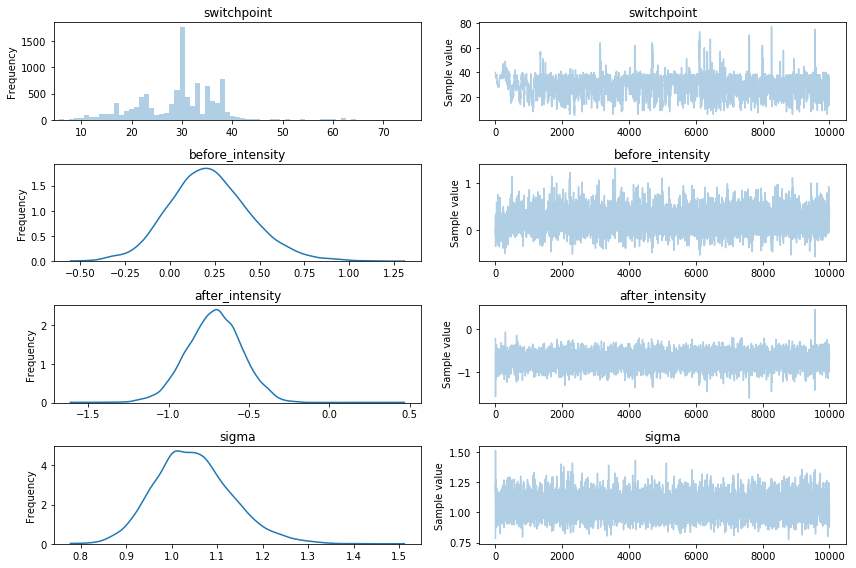

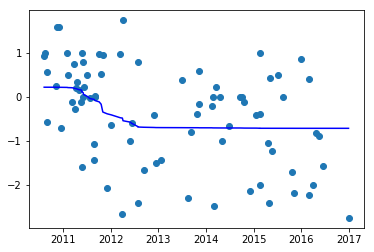

In [3]:
#Query the reviews database to get all of the reviews associated with the 30th business_id in the business database
business_reviews = query_business_reviews(business_data_from_sql['business_id'].iloc[30],review_con)

#This line runs the probabilistic programming function I wrote to discover & characterize the tipping point
#in a restaurant that has a pretty good example of what I'm trying to find
difference, a_switchpoint, switch_p, d,e = mcmc_changepoint(business_reviews['date'],
            business_reviews['user_normed_stars'],mcmc_iter=10000,plot_result=1)

#In the trace plot below, the most intersting thing is the upper left panel "switchpoint" which shows the
#histogram of where the MCMC algorithm put the switch from one normal disribution to the other. You can see that
#it's pretty constrained between the 20th and 40th review. The two plots below that show the estimated
#distributions for the mean of the before and after switchpoint normals. The way to read this is that before the
#switch point, the most likely mean review is around .25--or slightly above average--but after the switchpoint
#the mean review is around -.75, meaning a drop of about a full star. 

#Finally, at the very bottom you can see a plot of the review history. Each circle is one review, and the line
#is the estimate from the probabilistic programming (i.e. each iteration of the function finds a step function
#and the line is the average of all of those step functions)

## (2) How frequent are tipping points?

How frequent are large tipping points?


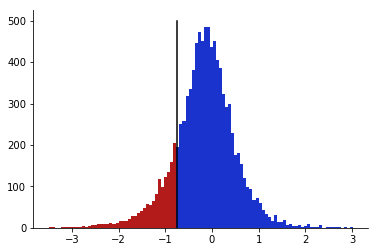

In [4]:
#First, I query the switchpoint database to find wall of the businesses 
#that have large changes after a "tipping point."
switches_df = query_business_switchpoints(switch_con)

#Differential stores the values of the change (before tipping-after tipping). 
#Here I make sure that the values are stored in the rigth format (i.e. as float)
t_busi_changes = switches_df['Differential'].values
busi_changes = [float(x) for x in t_busi_changes]
busi_changes = np.array(busi_changes)

print('How frequent are large tipping points?')

#Create a histogram showing the magnitude of tipping points. (I multiply by -1 so losses are on the left)
p, bins, patches = plt.hist(-1*np.array(busi_changes), bins=100,color= (.1,.2,.8))

#I then color anything that is has a "large" tipping point (3/4ths a star) as red

#(Note I put the visualization threshold at -.8 rather than the -.75 cutoff I actually use
#This is because if I choose -.75 it aliases the graph. This means that my visualization is
#in theory a little conservative--i.e. it shows a handful fewer than there really are. However,
#in practice this doesn't matter because I'm going to draw a black line that obscures this part
#of the plot--I just don't want there to be confusing mixes of colors around it).
for patchnum in range(len(patches)):
    if bins[patchnum] <= -.8: 
        patches[patchnum].set_facecolor((.7,.1,.1))

#Draw a black line to indicate where our cut off is
p = plt.plot([-.75,-.75],[0,500],'k')
ax = plt.gca()
ax.set_facecolor('white')
ax.tick_params('both',color='black')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

#Save the x-axis limits so we can make other visualizations parallel to it 
hist_lims = ax.get_xlim()

## (3) Are tipping point restaurants less likely to stay open?

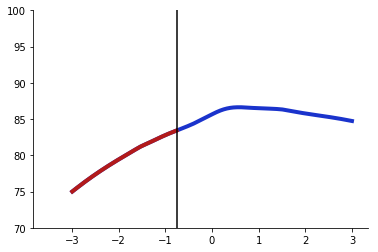

In [5]:
#For my third visualization I wanted to see whether these tipping points matter-- afterall, it's an
#exploratory idea of mine that they exist at all, and although they're prominent in the above histogram
#it has a normal distribution which could just indicate that they're noise rather than a distinct subset.
#The one encouraging part is that the DECREASES are far more likely to occur than INCREASES, suggesting 
#there might be something real going on.

#If tipping points are real, then they should hurt a business, and we might expect restaurants with 
#tipping points to be less likely to stay open. 

thresh = []
closed_p = []

#In this for loop I want to get the probability that restaurants are open based on the magnitude of their
#tipping points. To do this I'm going to take averages within a window centered on every possible magnitude
#of tipping point based on the range we saw above.

delta = .2 #This is the bin or window width: so if the tipping threshold is .1 then the bin is -.1:.3
s_threshes = np.arange(-3,3,.01)
for this_thresh in s_threshes:
    #Get the indicies where we're within the bin
    declines_ind = np.where(
        np.logical_and(busi_changes >= this_thresh-delta, 
                       busi_changes<=this_thresh+delta))[0] 
    #Now pull from the business database whether those buisnesses are open or closed
    closed = []
    for an_index in np.arange(0,len(declines_ind)):
        closed.append(business_data_from_sql['is_open'][declines_ind[an_index]] )

    #Record the center of this bin (the switchpoint threshold, and calculate the proportion of open places)
    thresh.append(this_thresh)
    closed_p.append(np.mean(closed))

    
#One problem with the above is that it's very very noisy, and depends pretty heavily on the bandwidth (delta)
#For visualization's sake, I'm going to apply locally weighted linea regression to create an easy-to-read 
#curve out of the points (x:threshold, y:probability) I created in the last step
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

lowessline = lowess(closed_p, thresh,frac=.5)

thresh = np.array(thresh)
lowessline = np.array(lowessline)

#Plot the function we estimated:
plt.plot(-1*thresh,lowessline[:,1]*100,color= (.1,.2,.8),linewidth=4) 

#Now color the "tipping points" below our threshold in red:
inds = np.where(-1*thresh < -.75)
plt.plot(-1*thresh[inds],lowessline[inds,1].flatten()*100,color= (.7,.1,.1),linewidth=4) 

#Plot a black line to show our definition of tipping points
ax = plt.gca()
linestart = ax.get_ylim()
plt.plot([-.75,-.75],[70,100],'k')

ax.set_facecolor('white')
ax.tick_params('both',color='black')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim(hist_lims)
plt.ylim([70,100])

plt.show()



# Step 3: Construct the data set & perform feature engineering

## In this section I pull reviews from tipping points and stable periods. I then split these into training and testing sets and extract the features to enter into the model. At the end of this section I will have: <br><br> (1) A bag of words representation of each review in the set <br><br> (2) A part-of-speech distribution (i.e. how many nouns, verbs, etc) for each review <br><br> (3) A sentiment analysis of each review as well as the sentiment of words occuring near mentions of the "server" <br><br> (4) Simple statistics of each review (e.g. number of words) 

In [ ]:
#############################################################################################################
#NOTE: this cell takes a while to run
#############################################################################################################

#What we need to do next is actually create a dataset of reviews that come from tipping points and reviews
#that come from stable periods. So far we've just been looking at businesses that have or do not have these
#tipping points.

#Define some important parameters for what to include in the dataset

#How many reviews do I want to sample from each business?
num_samples = 10 #I use ceil, so it actually can be num_samples+1

#What's the minumum number of reviews allowed (i.e. we don't want the first review to be a tipping point)
minimum_switch = 10 
    
#Query the switchpoint dataframe (in case we skipped the visualization cells)
switches_df = query_business_switchpoints(switch_con)

business_trajectory = [] #This will be our dependent variable
all_reviews = [] #This will be a list of all the pre-processed review text
tipping_location = [] #Record when in the business' run the tipping point occurs
numeric_features = np.empty( (14,) ) #This will hold the features we engineer within the sample_review function

busi_count = 0
print(len(switches_df['business_id'])) 
switch_df_ids = switches_df['business_id']
for busi_ind in switches_df['business_id']:

    #Get the review at which the switchpoint occured for this busines id
    business_switchpoint = switches_df['SwitchPoint'].loc[ switches_df['business_id'] == busi_ind ].values[0]
    business_switchpoint = int(business_switchpoint)
    #Get the size of that switchpoint
    business_differential = switches_df['Differential'].loc[ switches_df['business_id'] == busi_ind ].values[0]
    business_differential = float(business_differential)
    
    #Determine the label we'd give to reviews around the switchpoint: stable or tipping
    #If the change after the switchpoint is large, label it tipping; else label it stable
    business_classification = get_business_class(business_differential)
    
    if business_switchpoint > minimum_switch:
    
        busi_count += 1
        print(busi_count)
            
        #Get all reviews for this business
        business_reviews = query_business_reviews(busi_ind,review_con)
        
        #Get the N reviews around the switchpoint, preprocess (i.e. lemmatize) them, and derive simple statistics
        review_samples, review_features = sample_reviews(business_reviews,business_switchpoint,num_samples)
                
        print('Business #' + str(busi_ind) + ' had ' 
              + str(len(review_samples)) + ' reviews (switch: ' 
              + str(business_switchpoint) + ' length: ' + str(len(business_reviews)) + ')')

        if len(review_samples)>0:
            #Append this to tipping locations ONLY if there's a real tipping point
            if business_classification == 1:
                tipping_location.append(business_switchpoint/len(business_reviews))
            
            #Add all of these to our lists
            for a_review_sample in review_samples:
                business_trajectory.append(business_classification)
                all_reviews.append(a_review_sample)

            numeric_features = np.vstack([numeric_features,review_features])

#Because we began the numeric features as an empty Numpy array, we have an extra empty row at the beginning
numeric_features = numeric_features[1:]

#This code is to show where tipping points are most likely to occur during a restaurant's run.
#It makes clear that tipping points are more likely towards the end.
plt.hist(tipping_location,bins=100,color='cyan')
ax = plt.gca()
ax.set_facecolor('white')
plt.show()

9633
1
Business #826djy6K_9Fp0ptqJ2_Yag had 11 reviews (switch: 53 length: 68)
2
Business #YPavuOh2XsnRbLfl0DH2lQ had 11 reviews (switch: 625 length: 1276)
3
Business #93otbGHE0s0m-lU1osvg9w had 11 reviews (switch: 73 length: 102)
4
Business #L_thK7r3K_h5M4tV7amEKQ had 11 reviews (switch: 67 length: 118)
5
Business #J3H6VSIgUTlACkb_HPFA8w had 6 reviews (switch: 136 length: 137)
6
Business #TegeuAoYBVgQRUBiDLU7Mw had 5 reviews (switch: 52 length: 52)
7
Business #ZUvAR3I1uhC27zQFcRXumw had 5 reviews (switch: 77 length: 77)
8
Business #V94gk_Vx0Ot623UGHG6PrA had 11 reviews (switch: 84 length: 105)
9
Business #A2pZTpFXWC38z506XIhnBQ had 11 reviews (switch: 28 length: 41)
10
Business #mRv3Z25F56qduMKnvnCkVA had 11 reviews (switch: 16 length: 41)
11
Business #QfWFxmXqRGixztgaZN0gOA had 9 reviews (switch: 42 length: 46)
12
Business #h7uxML49NQ_Wj-7zk0DSqg had 6 reviews (switch: 40 length: 41)
13
Business #IikkB8j2E-1QmujRsPh5wQ had 11 reviews (switch: 11 length: 73)
14
Business #q_KQbgnaYDlPx

### Finally, let's get a count of how many reviews we had to consider to get find these tipping points

In [7]:
how_many = 0
for busi_ind in switches_df['business_id']:
    how_many += business_data_from_sql['review_count'].loc[business_data_from_sql['business_id']==busi_ind].values
    
print('We considered ' + str(how_many[0]) + ' reviews from ' 
      + str(len(switches_df['business_id'])) + ' different businesses.' )


We considered 1481513 reviews from 9633 different businesses.


## Split into training and testing sets

In [21]:
#At this point, split into Train and Test sets. 

#(Note, I don't split into an explicit validation set here because if I need to I just split the train set)
decline_ind = np.where(np.array(business_trajectory)==1)[0]
stable_ind = np.where(np.array(business_trajectory)==0)[0]
incline_ind = np.where(np.array(business_trajectory)==-1)[0]

############################################################################################
#First subsample the data so there are even numbers of stable period & tipping point reviews
############################################################################################

#Randomly shuffle the indicies
np.random.seed(seed=12345678)
np.random.shuffle(decline_ind)
np.random.shuffle(stable_ind)
np.random.shuffle(incline_ind)

#Now subselect stable indicies to match the number of tipping points
stable_ind = stable_ind[np.arange(0,len(decline_ind)+1)]

############################################################################################
#Second, split into a train set with 66% of reviews and a test set with 34%
############################################################################################

#Cut both stable and tipping inds into training and testing sets
train_length = int(np.floor(len(decline_ind) * .66))
test_endpoint = int(len(decline_ind))

#Train set indicies
stable_train_ind = stable_ind[np.arange(0,train_length)]
decline_train_ind = decline_ind[np.arange(0,train_length)]

#Test set indicies
stable_test_ind = stable_ind[np.arange(train_length+1, test_endpoint)]
decline_test_ind = decline_ind[np.arange(train_length+1, test_endpoint)]

############################################################################################
#Third, merge the train stable and train decline indicies together to form a single list of
#training set indicies. Then do the same procedure for the testing set indicies
############################################################################################

train_ind = []
train_ind.append(stable_train_ind)
train_ind.append(decline_train_ind)
test_ind = []
test_ind.append(stable_test_ind)
test_ind.append(decline_test_ind)

train_ind = np.array(train_ind).flatten()
test_ind = np.array(test_ind).flatten()

#Now shuffle these so they're not sorted
np.random.shuffle(train_ind)
np.random.shuffle(test_ind)

############################################################################################
#Finally, apply these indicies to divide the features/labels into training and testing sets
############################################################################################
all_reviews = np.array(all_reviews)
business_trajectory = np.array(business_trajectory)
numeric_features = np.array(numeric_features)

train_reviews = all_reviews[train_ind]
train_numeric_features = numeric_features[train_ind]
train_trajectory = business_trajectory[train_ind]

test_reviews = all_reviews[test_ind]
test_numeric_features = numeric_features[test_ind]
test_trajectory = business_trajectory[test_ind]

## Get bag of words representation and run other NLP analyses

In [18]:
#Now that we've split the reviews into the training and testing sets, we can get our bag of words for each.
#The important part is that we have to build our vocabulary--and pickle our vectorizer--on the training set
tfid_train_reviews, nlp_feature_names = create_nlp_features(train_reviews,is_training=True)
#We can then apply the exact same vectorizer to the testing set. 
tfid_test_reviews, nlp_feature_names = create_nlp_features(test_reviews,is_training=False)

#Create a list of features corresponding to the parts of speech within each review
train_pos_dist = []
for review in train_reviews:
    train_pos_dist.append(get_pos_dist(review))

test_pos_dist = []
for review in test_reviews:
    test_pos_dist.append(get_pos_dist(review))

#Now do the same for the sentiment around any mention of the server
train_service_mentions = []
for review in train_reviews:
    train_service_mentions.append(service_complaint(review))

test_service_mentions = []
for review in test_reviews:
    test_service_mentions.append(service_complaint(review))

#Compile the numeric feature names
continuous_feature_names = ['negative', 'neutral', 'positive', 'composite', 
                            'positive to negative ratio', 'service sentiment', 
                            'rating', 'normed_rating', 'useful', 'num_words', 
                            'current mean rating', 'slope', 'rating standard deviation', 
                            'rating ratio', 'nouns', 'adjectives','adverbs','verbs', 
                            'adjectives:nouns', 'adverb:verb', 'verb:noun', 'server_mentions', 
                            'wait_mentions', 'sick_mentions', 'chef_mentions', 'empty_mentions', 
                            'ill_mentions', 'temperature_mentions', 'change_mentions', 'switch_mentions', 
                            'expensive_mentions', 'forgot_mentions','service_mentions']

all_feature_names = []
all_feature_names.extend(nlp_feature_names)
all_feature_names.extend(continuous_feature_names)

#Stack all the engineered features together and rescale them
train_continuous_features = np.hstack( 
    [train_numeric_features, np.array(train_pos_dist), np.array(train_service_mentions)] )
test_continuous_features = np.hstack( 
    [test_numeric_features, np.array(test_pos_dist), np.array(test_service_mentions)] )

scaled_train_features = scale_features(train_continuous_features,is_training=True)
scaled_test_features = scale_features(test_continuous_features,is_training=False)

train_data = sparse.hstack( [tfid_train_reviews, scaled_train_features] ).tocsc()
test_data = sparse.hstack( [tfid_test_reviews, scaled_test_features] ).tocsc()

train_X = train_data
train_y = train_trajectory
test_X = test_data
test_y = test_trajectory

## Everyone loves wordclouds...

If we just look at the words present....
Stable periods


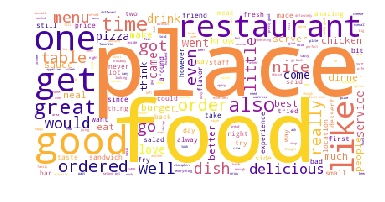

Tipping points


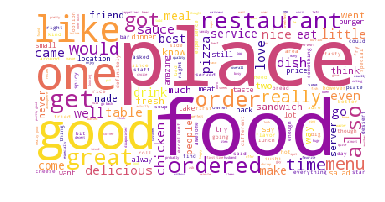

In [10]:
#Now that we've collected all of the specific reviews we're going to use in our modeling problem, it's good
#to just take a look at the most frequently used words to see if anything pops out that might be useful a prior.

#I prefer to look *only* at the training set--I recognize it's important to ensure that the training and testing
#sets are from the same underlying distributions, however, this is true by construction because I pull them 
#randomly from the same set of businesses. 

#I am more wary of basing my modeling around something idiosyncrating to the particular training-testing split. 
#And, in this case it doesn't matter because it's clear that absolute word frequency alone won't be enough.

#I want to create spearate wordclouds for the stable and tipping point reviews
s_ind = np.where(np.array(train_trajectory)==0)
t_ind = np.where(np.array(train_trajectory)==1)

s_words = np.array(train_reviews)[s_ind]
t_words = np.array(train_reviews)[t_ind]

stopword_set = set(stopwords.words('english'))
    
###Add Matplotlib colormaps
wc_color_map = 'plasma'

#Create wordclouds without adding in stopwords to show how difficult this is
print('If we just look at the words present....')
print('Stable periods')
wordcloud = WordCloud(
    stopwords=stopword_set,colormap = wc_color_map, background_color='white').generate(' '.join(s_words))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print('Tipping points')
wordcloud = WordCloud(
    stopwords=stopword_set,colormap = wc_color_map, background_color='white').generate(' '.join(t_words))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Step 4: Modeling

## Model 1: Logistic Regression (this is what I ultimately used)

CV grid search param performance:0.535348025311 0.001 0.05


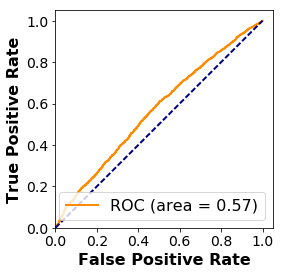

0.550423728814


In [22]:
#Here I build a logistic regression with elastic net regularization
model = SGDClassifier(loss='log',class_weight='balanced', penalty='elasticnet',n_iter=100) #alpha=0.0001, l1_ratio=0.15, n_iter=100)

#Grid search to find the ideal hyperparameters for the elastic net
hyper_parameters = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], 
                     'l1_ratio': [0.05, .15, .25, .35, .45, .55, .65, .75, .85, .95]},
cv_model = model_selection.GridSearchCV(model, hyper_parameters, cv=5)
cv_model.fit(train_X,train_y)

best_alpha = cv_model.best_estimator_.alpha
best_l1_ratio = cv_model.best_estimator_.l1_ratio
 
print('CV grid search param performance:' + str(cv_model.best_score_) + ' ' + str(best_alpha)+ ' ' + str(best_l1_ratio))

#Construct a model with those parameters
model = SGDClassifier(loss='log',class_weight='balanced', penalty='elasticnet',n_iter=100,alpha=best_alpha, l1_ratio=best_l1_ratio)
model.fit(train_X,train_y)

#Save the model so we can port it to AWS & power the website
saved_weights = pickle.dump(model, open( "logistic_weights", "wb" ) )

#Calculate performance
performance = model.score(test_X,test_y)

#Save the coefficients to invesigate feature importance
coefs = model.coef_ 

#Create an ROC plot
switch_probabilities = model.predict_proba(test_X)
make_roc(test_y,switch_probabilities[:,1],plot_me=1)
    
print(performance)

## Logistic Regression Feature Importance

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
['aaron' 'plate' 'plat' 'plastic fork' 'plastic container' 'plastic bag'
 'plastic' 'plantain' 'planta' 'plant']


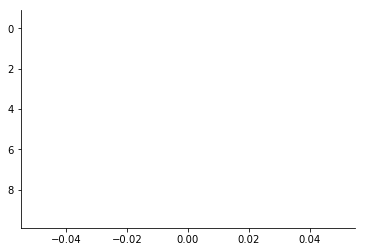

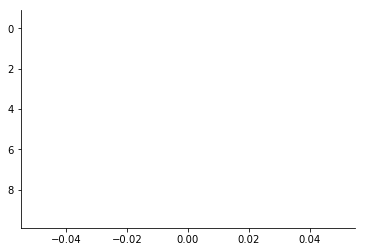

['être' 'fry fresh' 'fry bread' 'fry burger' 'fry came' 'fry chicken'
 'fry chip' 'fry cold' 'fry cooked' 'fry crispy']
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [17]:
N=10 #How many features do we want to look at?

coefs = coefs.flatten()
coef_inds = coefs.argsort()

plt.barh(np.arange(N),np.abs(coefs[coef_inds[:N]]), color = (.7,.1,.1) )
all_feature_names = np.array(all_feature_names)
print(coefs[coef_inds[:N]])
print(all_feature_names[coef_inds[:N]])

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.gca().invert_yaxis()
plt.show()

plt.barh(np.arange(N),np.flip(np.abs(coefs[coef_inds[-N:]]),axis=0), color = (.1,.2,.8))
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.gca().invert_yaxis()
plt.show()
print(np.flip(all_feature_names[coef_inds[-N:]],axis=0))
print(coefs[coef_inds[-N:]])

## Model 2: Multinomial Naive Bayes

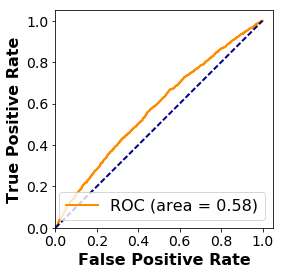

(9166, 30000)
(4720, 30000)


In [25]:
plt.rcParams['axes.facecolor']='white'

model = MultinomialNB(alpha=15)

#Grid search to get the best smoothing parameter
hyper_parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 15, 30]} 
cv_model = model_selection.GridSearchCV(model, hyper_parameters, cv=5)
cv_model.fit(tfid_train_reviews,train_y)

best_alpha = cv_model.best_estimator_.alpha
model = MultinomialNB(alpha=best_alpha)

model.fit(tfid_train_reviews, train_y)
switch_probabilities = model.predict_proba(tfid_test_reviews)
make_roc(test_y,switch_probabilities[:,1],plot_me=1)

print(tfid_train_reviews.shape)
print(tfid_test_reviews.shape)

## Model 3: XGBoost

In [15]:
#Define a function for passing data to XGBoost
def train_XGB_model(train_data, train_labels, test_data, test_labels=None, seed=0, iterations=1000):
    """Function for training or cross-validating an XGBoost model"""
    param = {}
    param['objective'] = 'multi:softprob' #if doing reg: 'reg:linear'#if doing class: 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 4
    param['silent'] = 1
    param['num_class'] = len(set(train_labels))
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed
    #Add regularization parameters
    #param['lambda'] = .05 #Ridge; L2
    #param['alpha'] = .01 #LASSO; L1


    parameter_list = list(param.items())
    xgtrain = xgb.DMatrix(train_data, label=train_labels)
    
    if test_labels is not None: #i.e. we're doing cross-validation
        xgtest = xgb.DMatrix(test_data, label=test_labels)
        watchlist = [ (xgtrain,'train'), (xgtest,'test') ]
        model = xgb.train(parameter_list, xgtrain, iterations, watchlist, early_stopping_rounds=30)
    else: #we're making real predictions 
        xgtest = xgb.DMatrix(test_data)
        model = xgb.train(parameter_list, xgtrain, iterations)
    
    predicted_labels = model.predict(xgtest)
    return predicted_labels, model

0.523305084746


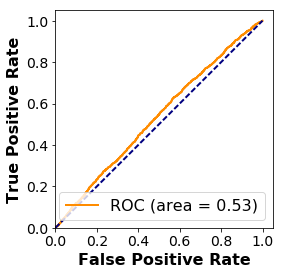

In [16]:
#Train the XGBoost
predictions, model = train_XGB_model(train_X,train_y,test_X,test_labels=None)

#Calculate its accuracy on the testing set
guesses = list(map(lambda x: np.argmax(x),predictions))
print(np.sum(guesses==test_y) / len(guesses))

#Plot its ROC curve
make_roc(test_y,predictions[:,1],plot_me=1)